#  semi-supervised anomaly detection

# What Is a Temporal Convolutional Network?

Temporal convolutional networks refer to a family of architectures that incorporate one-dimensional convolutional layers.

These convolutions are causal, meaning no information from the future is leaked into the past. In other words, the model only processes information going forward in time. 

Temporal convolutional networks don’t have this problem because they don’t rely on information from previous time steps, unlike recurrent neural networks, thanks to their casuality.

TCNs can map an input sequence of any length to an output sequence with the same length, just as a recurrent neural network (RNN) can do.

TCNs, the model might be required to remember varying levels of sequence history in order to make predictions. If the model did not have to take in as much history in the old task to make predictions, but in the new task it had to receive even more/less history to make predictions, that would cause issues
and might lead the model to perform poorly

In a one-dimensional convolutional layer, we still have parameter k to determine the size of our kernel, or filter. 

## Dilated Temporal Convolutional Network

Dilation Basically, when the dilation factor is greater than 1, we introduce gaps in the output data that correspond to the dilation factor. 

the spacing between each sampled entry has increased by one across all
directions. Vertically, horizontally, and diagonally, the sampled entries are all spaced apart by one entry. Essentially, this spacing is determined by finding what d – 1 is, where d is the dilation factor.

the difference between an acausal and a casual dilated convolution.

### acausal network

The first hidden layer has a dilation factor of two, and the second hidden layer has a dilation factor of four. Notice how inputs “forward in the sequence” contribute to the next layer’s node as well

### causal network

In a casual network, we only want information that we’ve learned up until the
present, so none of the information from the future will be accounted for in the model’s predictions.

The first hidden layer has a dilation factor of two, and the second hidden layer has a dilation factor of four. Notice how no inputs forward in the sequence contribute to the next layer’s node. This type of structure is ideal if the goal is to preserve some sort of flow within the data set, which is time in our case

# Encoder-Decoder Temporal Convolutional Network

The version of the encoder-decoder TCN you will be exploring involves a combination of one-dimensional causal convolutional and pooling layers to encompass the encoding stage and a series of upsampling and one-dimensional causal convolutional layers to comprise the decoding stage

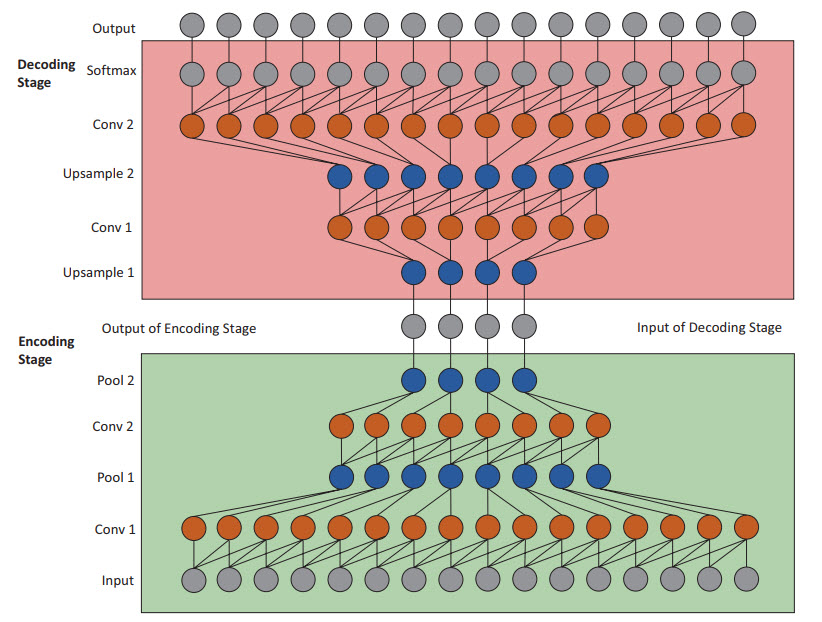

The encoding stage and start with the input layer at the very bottom perform a causal convolution on the input as part of the first convolutional layer.

The outputs of the first convolutional layer, which you will call conv_1, are now the inputs of the first max pooling layer, which you will call pool_1.

the pooling layer emphasizes the maximum value in the areas it passes through, effectively generalizing the inputs by choosing the heaviest values.

have another set of causal convolutions and max pooling with layers conv_2 and pool_2.

Note the progressive reduction in size of the data as it passes through the encoding stage, a feature characteristic to autoencoders.

Finally, you have a dense layer in the middle of the two stages, representing the final, encoded output of the encoding stage as well as the encoded input of the decoding stage.

The decoding stage is a bit different in this case, since make use of what is called upsampling. Upsampling is a technique in which you repeat the data n number of times to scale it up by a factor n. 

In the max pooling layers, the data is reduced by a factor of two. So, to upsample and increase the data by the same factor of two, you repeat the data twice. 

In this case, using one-dimensional upsampling, so the layer repeats
each step n times with respect to the axis of time. 

each upsampling layer is then connected to a onedimensional convolutional layer, and the pair of upsampling layer and one-dimensional convolutional layer repeats again until the final output is passed through a softmax function to result in the output/prediction.

# Library

In [1]:
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Dropout, Embedding, LSTM
from tensorflow.keras.optimizers import RMSprop, Adam, Nadam
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import regularizers

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report

In [7]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [4]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append(f'E:\gitlab\custom-script\script')
from ursar import describe,scoring,fe,anomaly_detection

%reload_ext autoreload

# Load data

In [5]:
filePath = f'E:/gitlab/machine-learning/dataset/creditcard.csv'
df = pd.read_csv(filepath_or_buffer=filePath, header=0, sep=',')
print(df.shape[0])
df.head()

284807


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
df['Amount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1, 1))
df['Time'] = StandardScaler().fit_transform(df['Time'].values.reshape(-1, 1))
anomalies = df[df["Class"] == 1]
normal = df[df["Class"] == 0]

In [8]:
describe.describe_data(df)

'table size 284807 x 31'

Dataframe has 31 columns.
There are 0 columns that have missing values.


,column_names,Data Type,Missing Values,% missing,low Value,Hi Value,stddev Value,unique
0,Time,float64,0,0.0,-2,2,1,124592.0
1,V1,float64,0,0.0,-56,2,2,275663.0
2,V2,float64,0,0.0,-73,22,2,275663.0
3,V3,float64,0,0.0,-48,9,2,275663.0
4,V4,float64,0,0.0,-6,17,1,275663.0
5,V5,float64,0,0.0,-114,35,1,275663.0
6,V6,float64,0,0.0,-26,73,1,275663.0
7,V7,float64,0,0.0,-44,121,1,275663.0
8,V8,float64,0,0.0,-73,20,1,275663.0
9,V9,float64,0,0.0,-13,16,1,275663.0


# split data

In [14]:
for f in range(0, 20):
    normal = normal.iloc[np.random.permutation(len(normal))]
    
data_set = pd.concat([normal[:2000], anomalies])

x_train, x_test = train_test_split(data_set, test_size = 0.4, random_state = 42)

x_train = x_train.sort_values(by=['Time'])
x_test = x_test.sort_values(by=['Time'])

y_train = x_train["Class"]
y_test = x_test["Class"]

x_train.head(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
367,-1.990939,1.146065,0.285853,0.562439,1.459336,-0.225891,-0.346303,0.131988,-0.085179,0.136365,...,-0.071473,0.076177,-0.030567,0.444843,0.650037,-0.335736,0.046372,0.020899,-0.327082,0
601,-1.987023,-3.133891,2.887394,2.178690,-1.576535,1.434510,-0.687313,3.816056,-3.416915,5.459274,...,-1.659610,-0.498518,-0.476668,0.302196,0.299993,-0.359155,-0.958818,-2.735623,-0.314648,0
623,-1.986644,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,...,0.661696,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,1.761758,1
646,-1.986265,-0.215043,0.652190,1.107882,1.265935,2.366300,4.393732,-0.412469,0.960644,-0.914003,...,0.103830,0.304199,-0.127455,0.994761,-0.501053,0.039003,0.024135,-0.056241,-0.339476,0
1062,-1.979631,1.121093,0.111322,0.498386,1.328600,-0.272976,0.001349,-0.110423,0.179641,0.174675,...,-0.053130,0.012710,-0.030376,0.216249,0.573753,-0.338610,0.030965,0.004415,-0.349231,0
1273,-1.975946,-0.370801,0.991591,1.156488,-0.119425,0.177933,-0.497759,0.532327,0.148150,-0.492472,...,-0.243260,-0.713885,-0.054271,-0.078738,-0.176470,0.078166,0.234831,0.083048,-0.338996,0
1293,-1.975504,1.217618,0.328141,0.134011,0.559108,0.062384,-0.370944,0.079110,-0.097848,-0.088550,...,-0.266200,-0.711597,0.093404,-0.300369,0.218634,0.142125,-0.003095,0.027700,-0.301494,0
1385,-1.973967,-0.295594,1.022747,1.534593,-0.189536,0.417759,-0.545109,0.998968,-0.327714,-0.409308,...,-0.293893,-0.556324,-0.123407,-0.099532,-0.108294,0.069227,0.107248,-0.103839,-0.317367,0
2062,-1.963017,1.257719,0.364739,0.306923,0.690638,-0.357792,-1.067481,0.094272,-0.210300,0.014455,...,-0.286856,-0.820658,0.127663,0.343128,0.221120,0.094391,-0.022189,0.030944,-0.348072,0
2939,-1.944275,0.941208,-0.155734,0.017869,1.043993,-0.189767,-0.400348,0.309017,-0.108247,-0.285065,...,0.147515,0.108525,-0.282262,0.025569,0.650362,-0.341466,-0.017651,0.032588,0.250642,0


To pass the data sets into the model, the x sets must be three-dimensional, and the y sets must be two-dimensional. You can simply reshape the x sets, and change the y sets to be categorical 

In [15]:
EDTCN,x_train,x_test,y_train,y_test,checkpointer = anomaly_detection.model_ed_tcn(x_train,x_test,y_train,y_test)

Shapes:
x_train:(1495, 31, 1)
y_train:(1495, 2)

x_test:(997, 31, 1)
y_test:(997, 2)

input_shape:(31, 1)



Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 31, 1)]           0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 31, 31)            93        
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 15, 31)            0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 15, 15)            945       
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 5, 15)             0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 5, 10)             310       
________________

In [16]:
EDTCN.fit(x_train, y_train,
          batch_size=128,
          epochs=25,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks = [checkpointer])

Train on 1495 samples, validate on 997 samples
Epoch 1/25
 640/1495 [===========>..................] - ETA: 2s - loss: 2.5561 - accuracy: 0.8031 
Epoch 00001: val_loss improved from inf to 2.00267, saving model to model_ED-TCN_creditcard.h5
1495/1495 [==============================] - 3s 2ms/sample - loss: 2.3521 - accuracy: 0.7980 - val_loss: 2.0027 - val_accuracy: 0.8014
Epoch 2/25
1024/1495 [===================>..........] - ETA: 0s - loss: 1.8414 - accuracy: 0.8311
Epoch 00002: val_loss improved from 2.00267 to 1.51647, saving model to model_ED-TCN_creditcard.h5
1495/1495 [==============================] - 0s 183us/sample - loss: 1.7735 - accuracy: 0.8502 - val_loss: 1.5165 - val_accuracy: 0.9288
Epoch 3/25
1024/1495 [===================>..........] - ETA: 0s - loss: 1.3807 - accuracy: 0.9531
Epoch 00003: val_loss improved from 1.51647 to 1.18198, saving model to model_ED-TCN_creditcard.h5
1495/1495 [==============================] - 0s 160us/sample - loss: 1.3380 - accuracy: 0.953

# evaluate

In [18]:
score = EDTCN.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

997/997 [==============================] - 0s 138us/sample - loss: 0.2054 - accuracy: 0.9679
Test loss: 0.2053715002348454
Test accuracy: 0.96790373


In [20]:
from sklearn.metrics import roc_auc_score

preds = EDTCN.predict(x_test)
y_pred = np.round(preds)
auc = roc_auc_score( y_pred, y_test)
print("AUC: {:.2%}".format (auc))

AUC: 97.60%


In [21]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       799
           1       0.99      0.85      0.91       198

   micro avg       0.97      0.97      0.97       997
   macro avg       0.98      0.92      0.95       997
weighted avg       0.97      0.97      0.97       997
 samples avg       0.97      0.97      0.97       997



In [27]:
y_pred2 = np.argmax(y_pred, axis=1)
y_test2 = np.argmax(y_test, axis=1)

comfusion matrix = 
[[797   2]
 [ 30 168]]

accuracy_score =  0.9679
balanced_accuracy_score =  0.923

precision score =  0.9882
average precision score =  0.8686
recall score =  0.8485

F1 score =  0.913
F2 score =  0.9567
F3 score =  0.9722
F_beta score =  0.9722
Matthews Correlation Coefficient score =  0.8974

AUC of Precision-Recall Curve on Testing =  0.9334
Best Threshold for Precision-Recall Curve = 1.000000
F-Score = 0.913
AUC of ROC =  0.923

Best Threshold for ROC = 1.000000
G-Mean = 0.920
Best Threshold with Youden’s J statistic = 1.000000

Cohens kappa =  0.8935
Gini =  0.8668

Expected Approval Rate =  0.1705
Expected Default Rate =  0.0118

classification_report
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       799
           1       0.99      0.85      0.91       198

    accuracy                           0.97       997
   macro avg       0.98      0.92      0.95       997
weighted avg       0.97      0.97      0.9

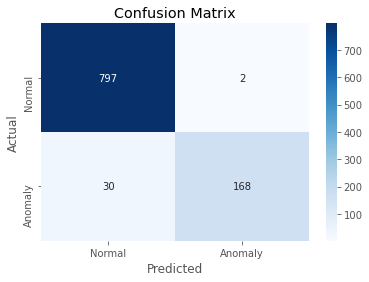

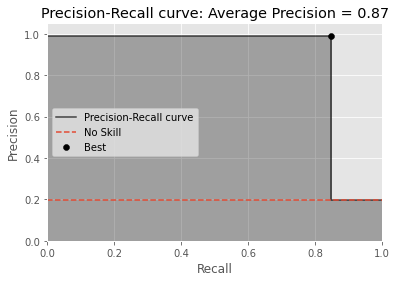

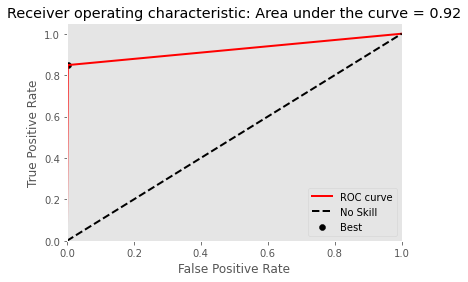


time span=  1


In [29]:
scoring.print_score(y_test2,y_pred2,y_pred2,labels=["Normal", "Anomaly"])